# Logistic Regression using cleaned data
This notebook uses the helper `get_clean_X_y()` from `data_utils` (same pattern as `naiveBayes.ipynb`) so we don't re-run cleaning steps. We perform hyperparameter tuning for Logistic Regression with GridSearchCV and evaluate the best model.

In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
#light weight pipelining
import joblib

In [2]:
# Load cleaned data from data_utils (reuses preprocessing from naiveBayes.ipynb)
from data_utils import get_clean_X_y
X, y = get_clean_X_y()
print('X shape:', X.shape)
print('y distribution:\n', y.value_counts())

X shape: (5644, 98)
y distribution:
 class
e    3488
p    2156
Name: count, dtype: int64


In [3]:
# Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (4515, 98) Test shape: (1129, 98)


In [4]:
# Train a basic Logistic Regression classifier
from sklearn.metrics import mean_squared_error

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Training and test accuracy
print('Training accuracy:', log_reg.score(X_train, y_train))
print('Test accuracy:', log_reg.score(X_test, y_test))

# Calculate MSE using probability predictions
# Convert labels to numeric for MSE calculation
y_train_numeric = (y_train == 'p').astype(int)
y_test_numeric = (y_test == 'p').astype(int)

# Get probability predictions for positive class (poisonous)
y_train_proba = log_reg.predict_proba(X_train)[:, 1]
y_test_proba = log_reg.predict_proba(X_test)[:, 1]

# Calculate MSE
train_mse = mean_squared_error(y_train_numeric, y_train_proba)
test_mse = mean_squared_error(y_test_numeric, y_test_proba)

print(f'Training MSE: {train_mse:.6f}')
print(f'Test MSE: {test_mse:.6f}')

Training accuracy: 1.0
Test accuracy: 1.0
Training MSE: 0.000179
Test MSE: 0.000196


In [5]:
# Nested stratified cross-validation (outer CV for unbiased estimate) and expanded hyperparameter grid
from sklearn.model_selection import StratifiedKFold, cross_val_score
# inner CV used by GridSearch (for hyperparameter tuning)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# outer CV used by cross_val_score to get an unbiased generalization estimate
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

param_grid = {
    # wide log-scale grid for regularization strength; even spacing between categorical values for features
    # prevents overfitting
    'C': np.logspace(-4, 4, 9),               
    # L2 is for preventing coefficients going to zero, L1 is used for zeroing out unimportant features,
    # elasticnet is the means of combining the l1 & l2
    'penalty': ['l1', 'l2', 'elasticnet'],    
    # saga supports l1, l2, elasticnet; its the means of gradient descent incorporating the rules
    'solver': ['saga'],                       
    # requirement for elasticnet; balances the use of L1 and L2
    'l1_ratio': [0.1, 0.5, 0.9]               
}

base = LogisticRegression(max_iter=2000, random_state=42) # base algorithm
grid_nested = GridSearchCV(base, param_grid, cv=inner_cv, scoring='accuracy', n_jobs=-1, verbose=2)

print(f"Running nested CV (outer_cv={outer_cv.get_n_splits()}, inner_cv={inner_cv.get_n_splits()}) — this may take a while...")
nested_scores = cross_val_score(grid_nested, X, y, cv=outer_cv, scoring='accuracy', n_jobs=-1)
print('Nested CV accuracy: mean={:.4f}, std={:.4f}'.format(nested_scores.mean(), nested_scores.std()))

# Refit GridSearch on the entire dataset (inner CV) to obtain final model
print('Refitting GridSearchCV on full data to get final estimator...')
grid_nested.fit(X, y)
print('Best params on full data:', grid_nested.best_params_)
print('Best inner-CV score on full data:', grid_nested.best_score_)

best_final = grid_nested.best_estimator_
joblib.dump(best_final, 'logistic_best_model_nested.joblib')
print('Saved final model to logistic_best_model_nested.joblib')

# Evaluate the final model on the held-out test set from the earlier stratified split
y_test_pred = best_final.predict(X_test)
print('Test accuracy (final model):', accuracy_score(y_test, y_test_pred))
print('\nClassification report:\n', classification_report(y_test, y_test_pred))


Running nested CV (outer_cv=5, inner_cv=5) — this may take a while...
Nested CV accuracy: mean=1.0000, std=0.0000
Refitting GridSearchCV on full data to get final estimator...
Fitting 5 folds for each of 81 candidates, totalling 405 fits


c:\Users\NicoD\anaconda3\envs\ML\Lib\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Best params on full data: {'C': 1.0, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}
Best inner-CV score on full data: 1.0
Saved final model to logistic_best_model_nested.joblib
Test accuracy (final model): 1.0

Classification report:
               precision    recall  f1-score   support

           e       1.00      1.00      1.00       698
           p       1.00      1.00      1.00       431

    accuracy                           1.00      1129
   macro avg       1.00      1.00      1.00      1129
weighted avg       1.00      1.00      1.00      1129



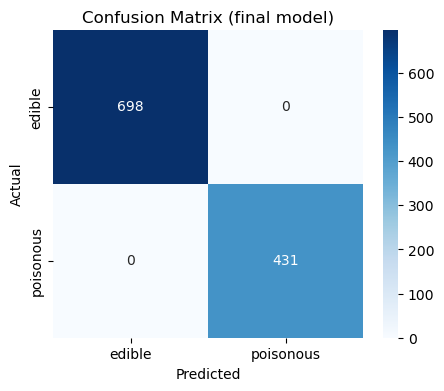

In [6]:
# confusion matrix visualiztion
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['edible','poisonous'], yticklabels=['edible','poisonous'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (final model)')
plt.show()

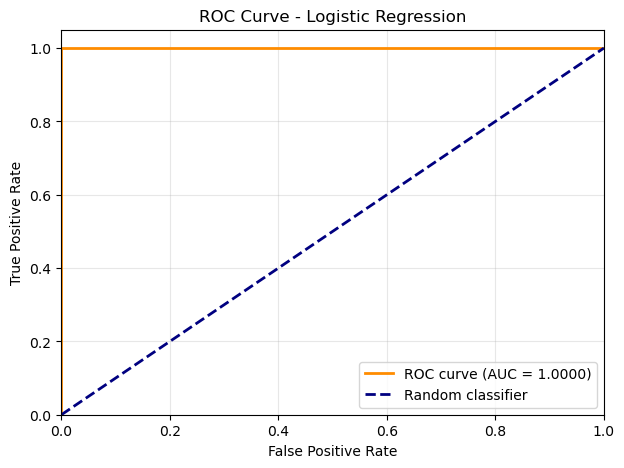

AUC Score: 1.0000


In [7]:
# ROC Curve visualization
from sklearn.metrics import roc_curve, roc_auc_score

# Get prediction probabilities for the positive class (poisonous = 'p')
y_test_proba = best_final.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba, pos_label='p')
auc_score = roc_auc_score(y_test, y_test_proba)

# Plot ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f'AUC Score: {auc_score:.4f}')

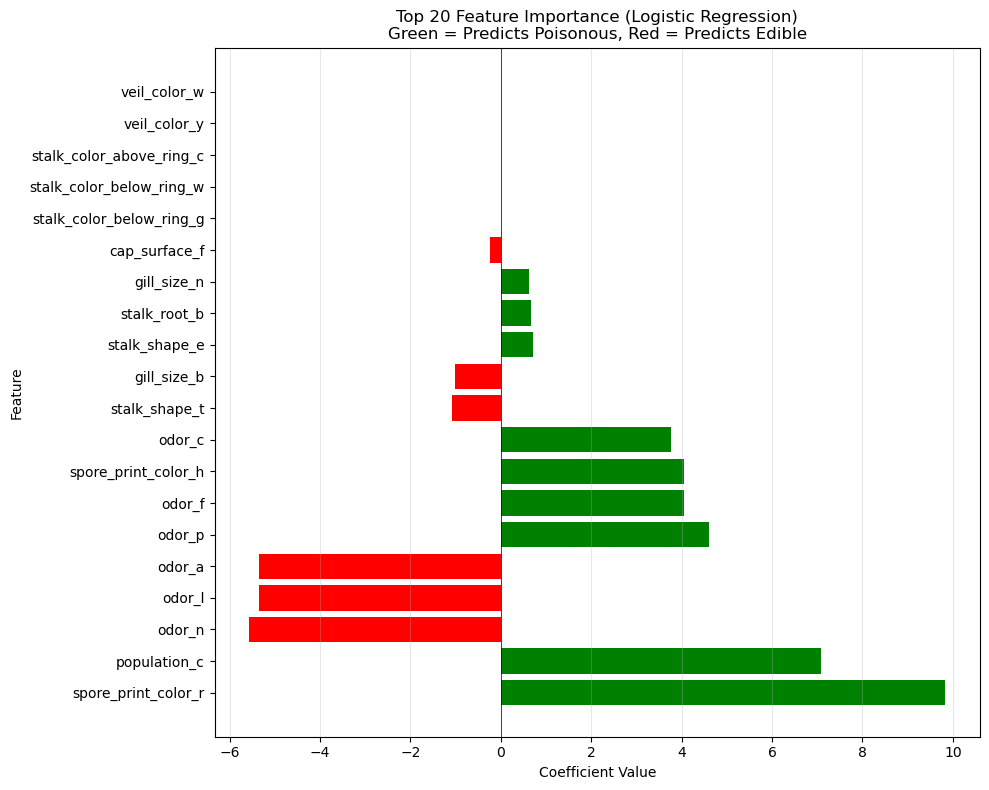


Total features: 98
Non-zero coefficients: 15


In [8]:
# Feature Importance visualization
# Get coefficients from the logistic regression model
coefficients = best_final.coef_[0]
feature_names = X.columns

# Create DataFrame for easier manipulation
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
})

# Sort by absolute value and get top 20
top_features = coef_df.sort_values('abs_coefficient', ascending=False).head(20)

# Plot top 20 features
plt.figure(figsize=(10, 8))
colors = ['red' if c < 0 else 'green' for c in top_features['coefficient']]
plt.barh(range(len(top_features)), top_features['coefficient'], color=colors)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importance (Logistic Regression)\nGreen = Predicts Poisonous, Red = Predicts Edible')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f'\nTotal features: {len(feature_names)}')
print(f'Non-zero coefficients: {np.sum(coefficients != 0)}')